# Mak et al, 2015

## Introduction

In this notebook we will identify PPMI subjects to reproduce the following paper:

<div class="alert alert-block alert-success"> E. Mak et al., <a href="https://academic.oup.com/brain/article/138/10/2974/2468704?login=false" style="text-decoration: none;">“Baseline and longitudinal grey matter changes in newly diagnosed Parkinson’s disease: ICICLE-PD study,”</a> Brain, vol. 138, no. 10, pp. 2974–2986, 2015.
</div>

This study involved 105 subjects with newly diagnosed idiopathic Parkinson’s disease (PD) and 37 healthy matched controls. 

Among the 105 PD subjects, they classified 39 subjects as PD with mild cognitive impairment (PD-MCI) and 66 subjects as PD with no cognitive impairment (PD-NC).

The demographics and clinical characteristics were as follows (table extracted from the paper):

<img src="images/cohort_table.jpeg"/>

The subjects had a serial 3 T structural magnetic resonance imaging (MRI) scans with clinical and neuropsychological assessments at baseline and, at 18 months follow-up.

These MRI were processed with Freesurfer, an image processing software, to measure the cortical thickness and subcortical volumes at baseline and follow-up. 

The key result of the paper reveals that PD-MCI shows more extensive atrophy and greater percentage of cortical thinning compared to PD-NC, as illustrated below in Table 2 and Figure 2C (extracted from paper) respectively. 

<img src="images/change_in_subcortical_volumes.jpeg"/>

<figure>
    
<img src="images/change_in_cortical_thinning.jpg"/>

<figcaption>
    <b>Figure 2C. Vertex-wise comparisons of percentage change in cortical thinning over 18 months.</b>
    The colour bar shows the logarithmic scale of P-values (−log10). Lh = left hemisphere; Rh = right hemisphere.</figcaption>

</figure>


The rest of this notebook aims at reproducing these results using the PPMI dataset.

## Importing modules

First, let's initialize the notebook by installing software dependencies and importing libraries that we're going to use.

In [1]:
import rich
import numpy as np
import pandas as pd
import livingpark_utils
from rich.table import Table
import matplotlib.pyplot as plt
from rich.console import Console
from itertools import combinations
from collections import defaultdict
from collections.abc import Iterable
from livingpark_utils.scripts import run
from livingpark_utils.maketal import maketal

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

removing link inputs
removing link outputs
Installing notebook dependencies (see log in install.log)... 
This notebook was run on 2022-10-13 21:43:16 UTC +0000


## Cohort Preparation

The first step in reproducing the paper is to build a PPMI cohort that looks the closest to Table 1. For this, we will use PPMI Study Data files.

## PPMI study data files download

The required PPMI study files to build the cohort are:

|Files|Used to retrieve|
|:---|:---|
|Demographics | gender|
|Age at visit | age|
|Socio-Economics| years of education|
|Participant Status | PD subjects and healthy controls|
|Cognitive Categorization | PD-MCI and PD-NC subjects| 
|PD Diagnosis History | disease duration| 
|MDS UPDRS Part III | Hoehn and Yahr scores|
|LEDD Concomitant Medication Log | LEDD scores|
|Montreal Cognitive Assessment MoCA | MoCA and MMSE scores|
|Geriatric Depression Scale Short Version | GDS scores|


We will use the LivingPark utils library to download these files from the notebook. 

In [2]:
required_files = [
    "Demographics.csv",
    "Age_at_visit.csv",
    "MDS_UPDRS_Part_III.csv",
    "Socio-Economics.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "Cognitive_Categorization.csv",
    "Participant_Status.csv",
    "Geriatric_Depression_Scale__Short_Version_.csv"
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


## LivingPark utility notebook download 

We will also import notebooks from LivingPark utils to clean data which produce the following files:

* <code>MRI_info.csv</code>: contains 3D T1-weighted images by visit
* <code>MDS_UPDRS_Part_III_clean.csv</code>: contains cleaned-up PDSTATE and PDTRTMNT

In [3]:
# run.mri_metadata()

In [4]:
# run.pd_status()

## Cohort Matching

Now that we have all the required files, we will start by preparing the data for cohort matching.

In [5]:
# Styling visualization plots
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['axes.facecolor'] = '#F2F5F9'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.color'] = 'white'
plt.rcParams["figure.autolayout"] = True
color = '#2A2A2A'

### Demographics characteristics

### Cohort Definition

First, we will extract participants defined as healthy controls and diagnosed with Parkinson's disease.

We obtain the following distribution of cohort in the PPMI dataset:

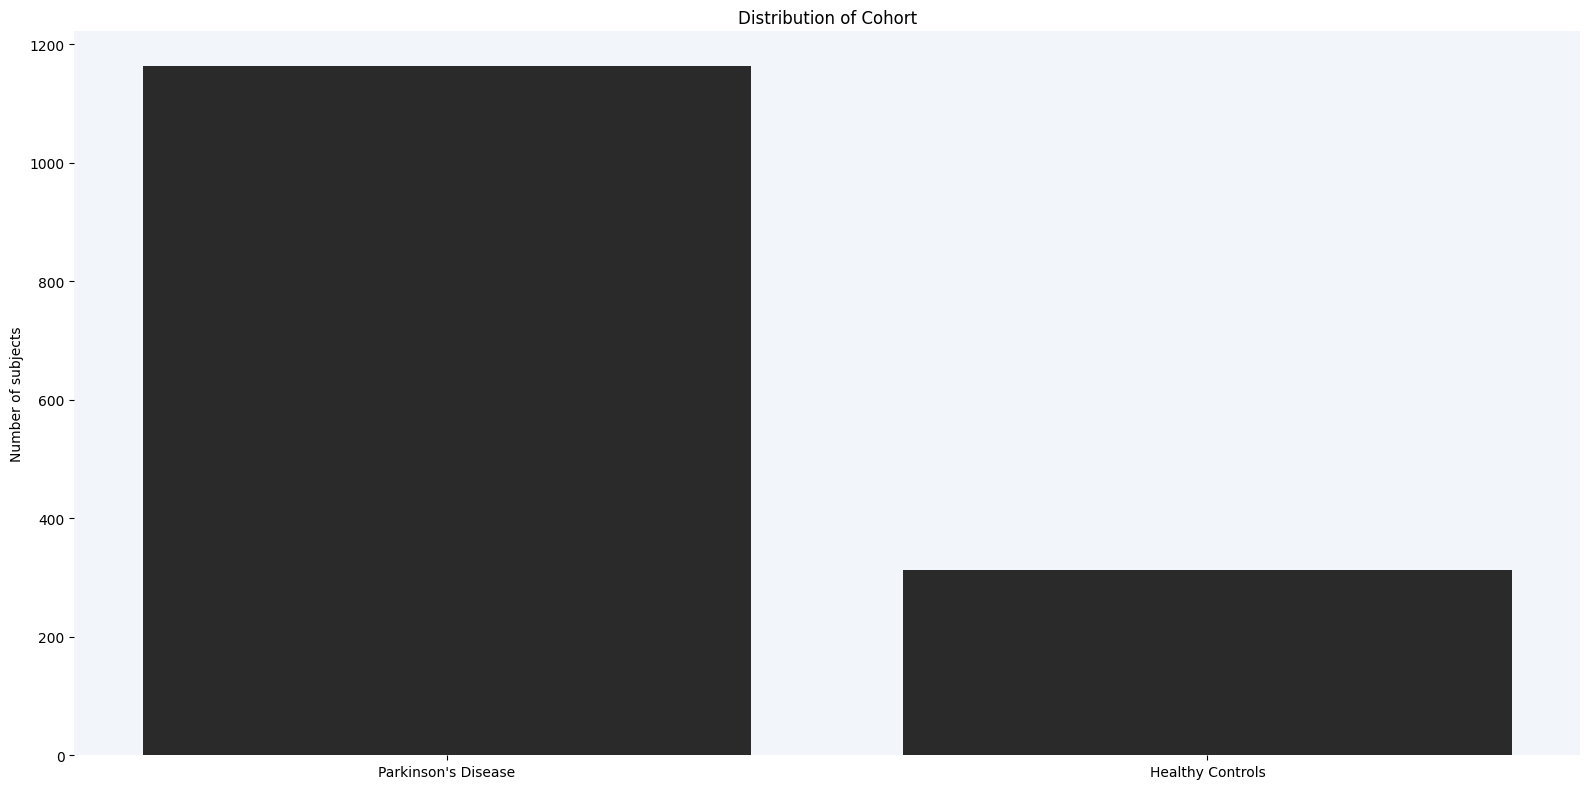

In [6]:
cohort_def = pd.read_csv("inputs/study_files/Participant_Status.csv", usecols=["PATNO", "COHORT"])
cohort_def = cohort_def[cohort_def["COHORT"].isin([1, 2])] # Only keep PD and HC.

cohort = cohort_def.groupby(["COHORT"]).size()
plt.bar(["Parkinson's Disease", "Healthy Controls"], cohort.values, color=color)
plt.ylabel("Number of subjects")
plt.title("Distribution of Cohort");

### Cognitive State

The original study differentiates between PD patients with and without MCI. 

We will consult PPMI's cognitive categorization to obtain its distribution. 

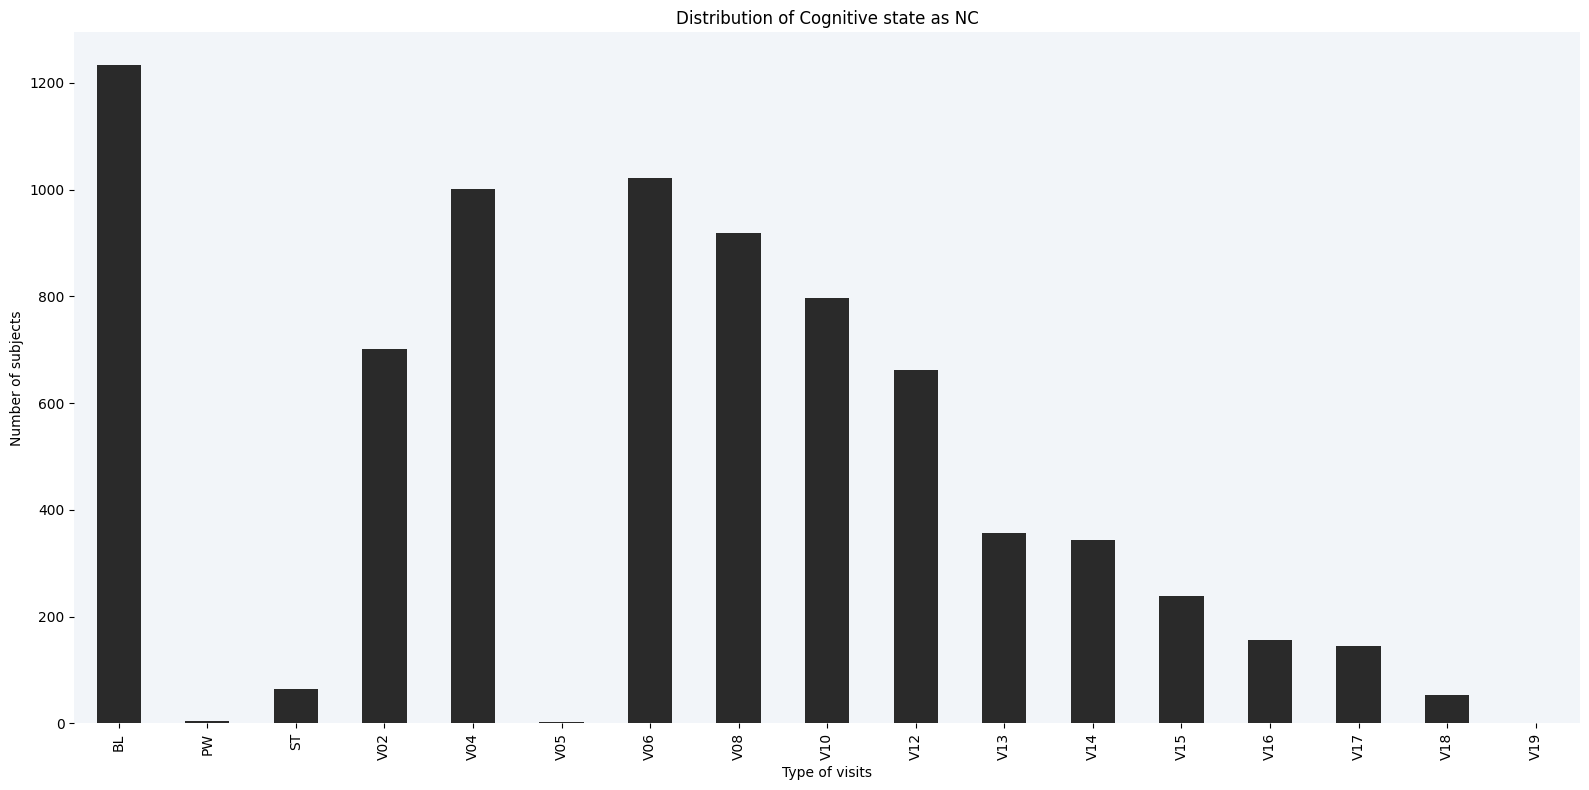

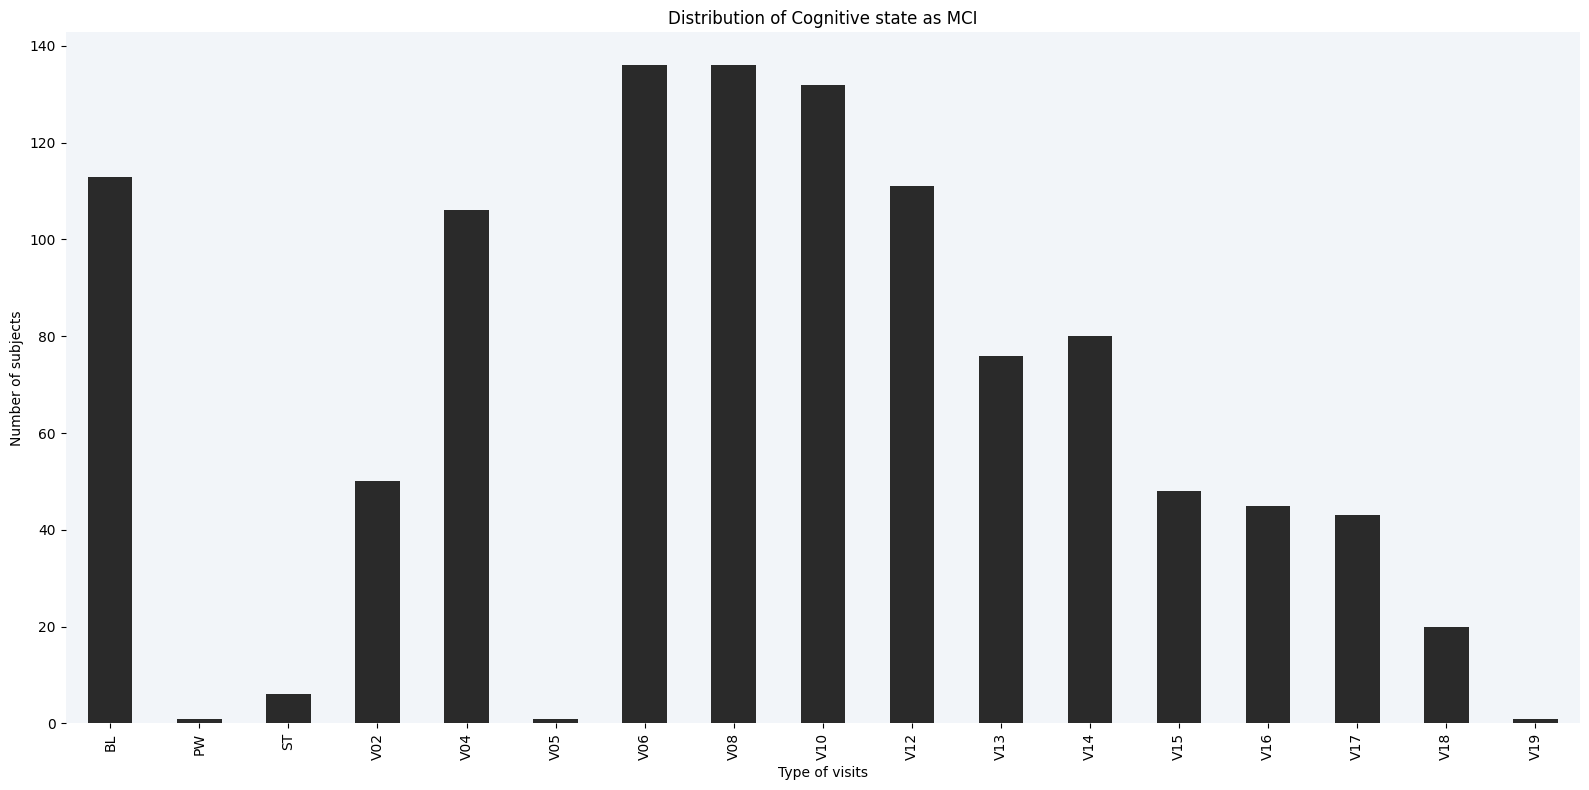

In [7]:
cogstate_df = pd.read_csv("inputs/study_files/Cognitive_Categorization.csv",
                          usecols=["PATNO", "EVENT_ID", "COGSTATE"])
# Drop nan
cogstate_df = cogstate_df[cogstate_df["COGSTATE"].notna()] 
# Dropping all subjects with PDD
cogstate_df = cogstate_df[cogstate_df["COGSTATE"] != 3] 

cogstate = cogstate_df.groupby(["COGSTATE", "EVENT_ID"])["PATNO"].nunique().rename({1: "NC", 2: "MCI"})
shared_index = np.intersect1d(cogstate["NC"].index, cogstate["MCI"].index)
cogstate["NC"][shared_index].plot.bar(title="Distribution of Cognitive state as NC", color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Type of visits")
plt.show()
cogstate["MCI"][shared_index].plot.bar(title="Distribution of Cognitive state as MCI", color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Type of visits")
plt.show()

Types of visits expressed as: BL-Baseline, PW-Premature Withdrawal, ST-Symptomatic Therapy, V<em>xx</em>-Visit <em>xx</em>

Based on the graph above, we see that the number of subjects with NC is significantly more. Therefore we will make sure to obtain MCI patients before NC ones.

### Age at visit

The patient's age was recorded at each visit. To keep it simple, we will only show the age distribution at baseline while considering the age at specific visits for the cohort.

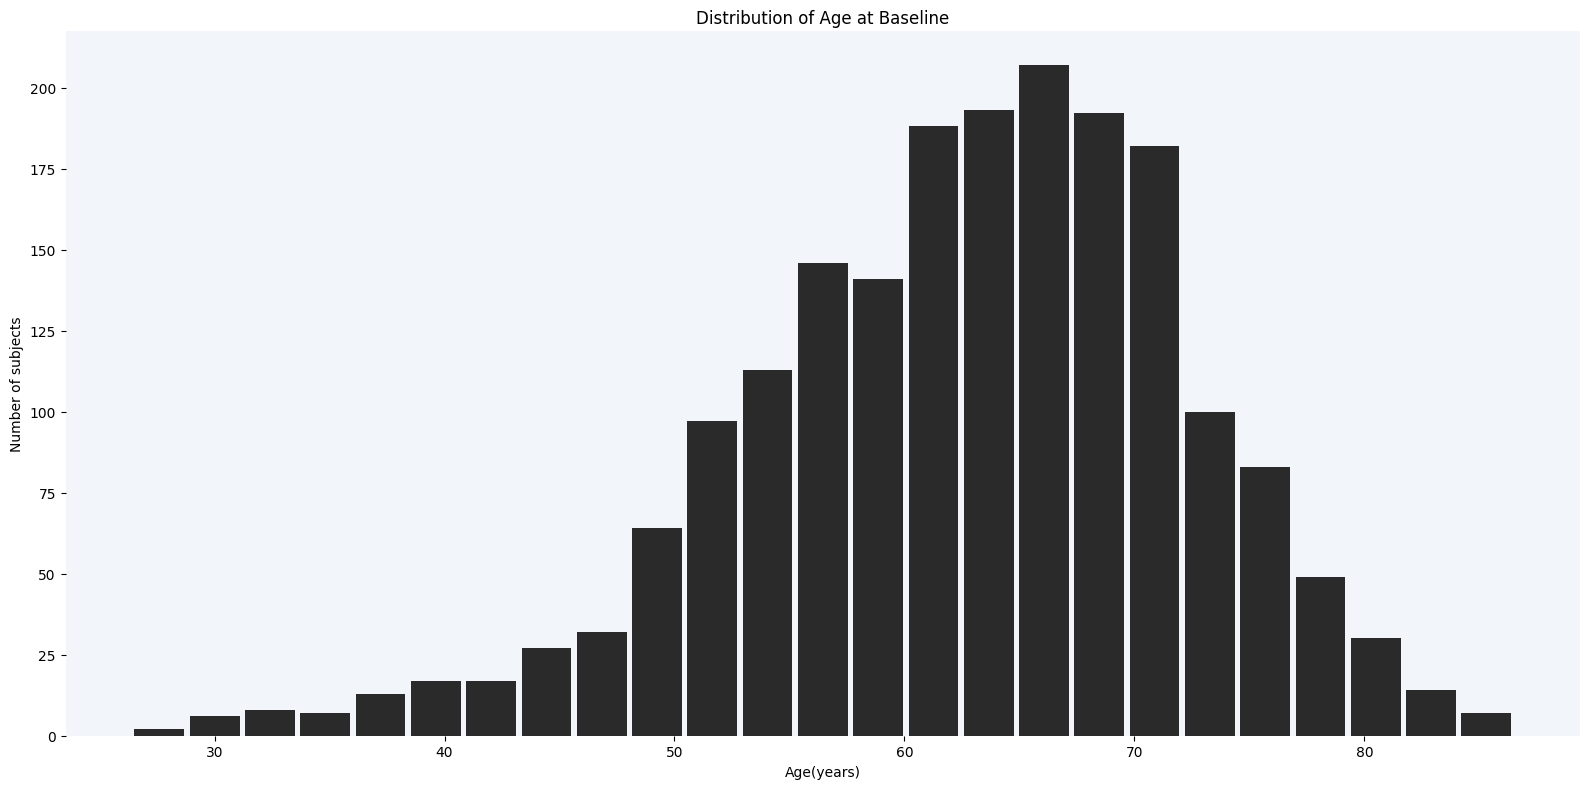

In [8]:
age_df = pd.read_csv("inputs/study_files/Age_at_visit.csv",
                     usecols=["PATNO", "EVENT_ID", "AGE_AT_VISIT"])

age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.xlabel('Age(years)')
plt.ylabel('Number of subjects')
plt.title("Distribution of Age at Baseline");

In [9]:
# Age range at baseline
print("Age Range: ", age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].min(), "-", 
      age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].max())

Age Range:  26.4 - 86.5


### Gender

We will look at PPMI's demographics to get the gender distribution.

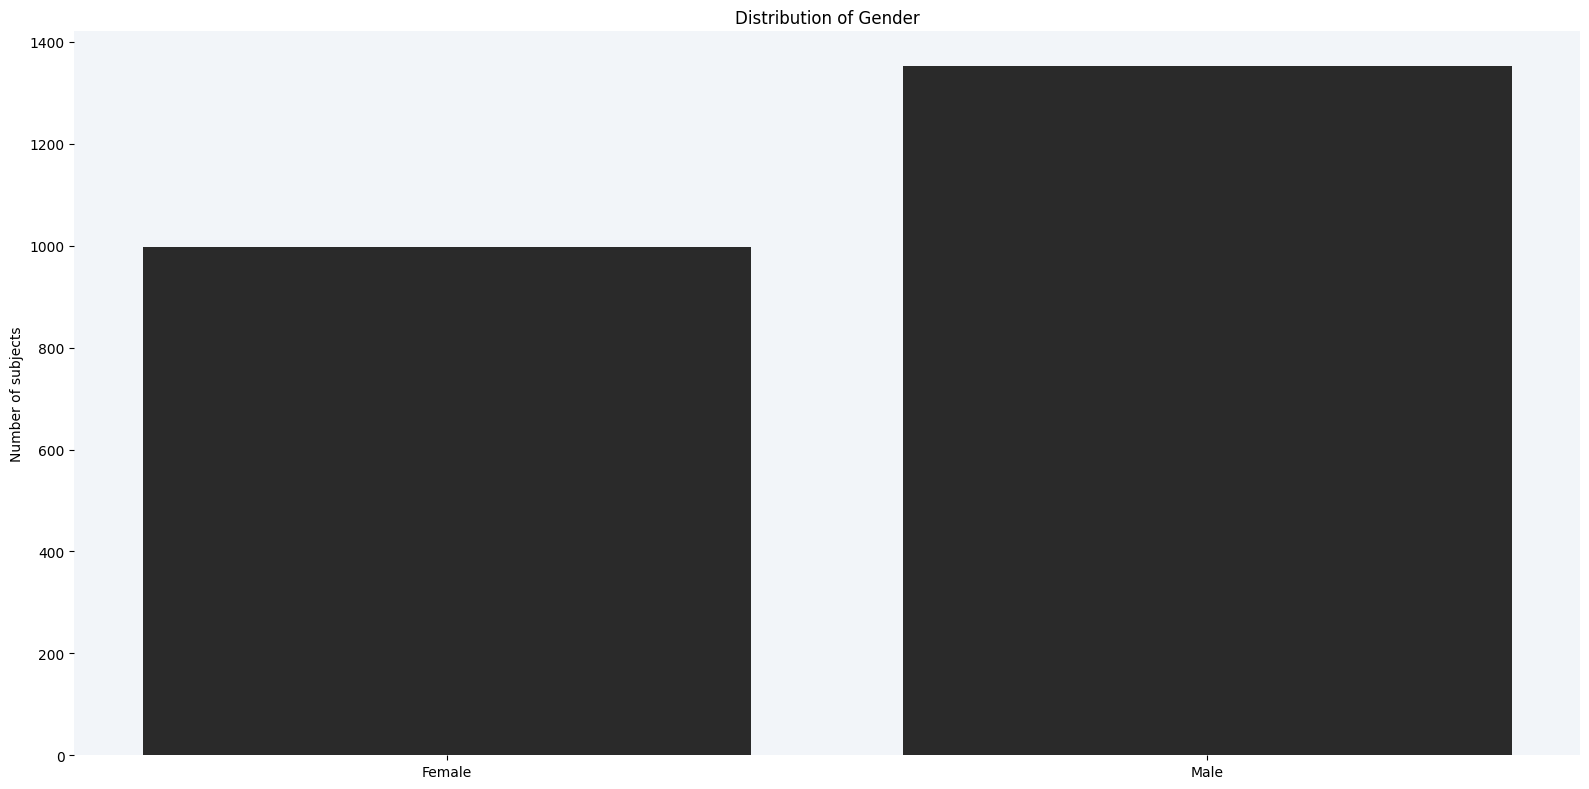

In [10]:
demo_df = pd.read_csv("inputs/study_files/Demographics.csv", usecols=["PATNO", "SEX"])
demo_df["SEX"] = demo_df["SEX"].astype(int)

gender = demo_df.groupby("SEX").size().rename({0: "Female", 1: "Male"})

plt.bar(gender.index, gender.values, color=color)
plt.ylabel("Number of subjects")
plt.title("Distribution of Gender");

### Education

While looking at PPMI's socioeconomics, we notice that in the graph below, the education years was mostly recorded at screening. Thus, we will only consider the latter as the other visits might limit the possibility to perform data aggregation for the cohort matching.

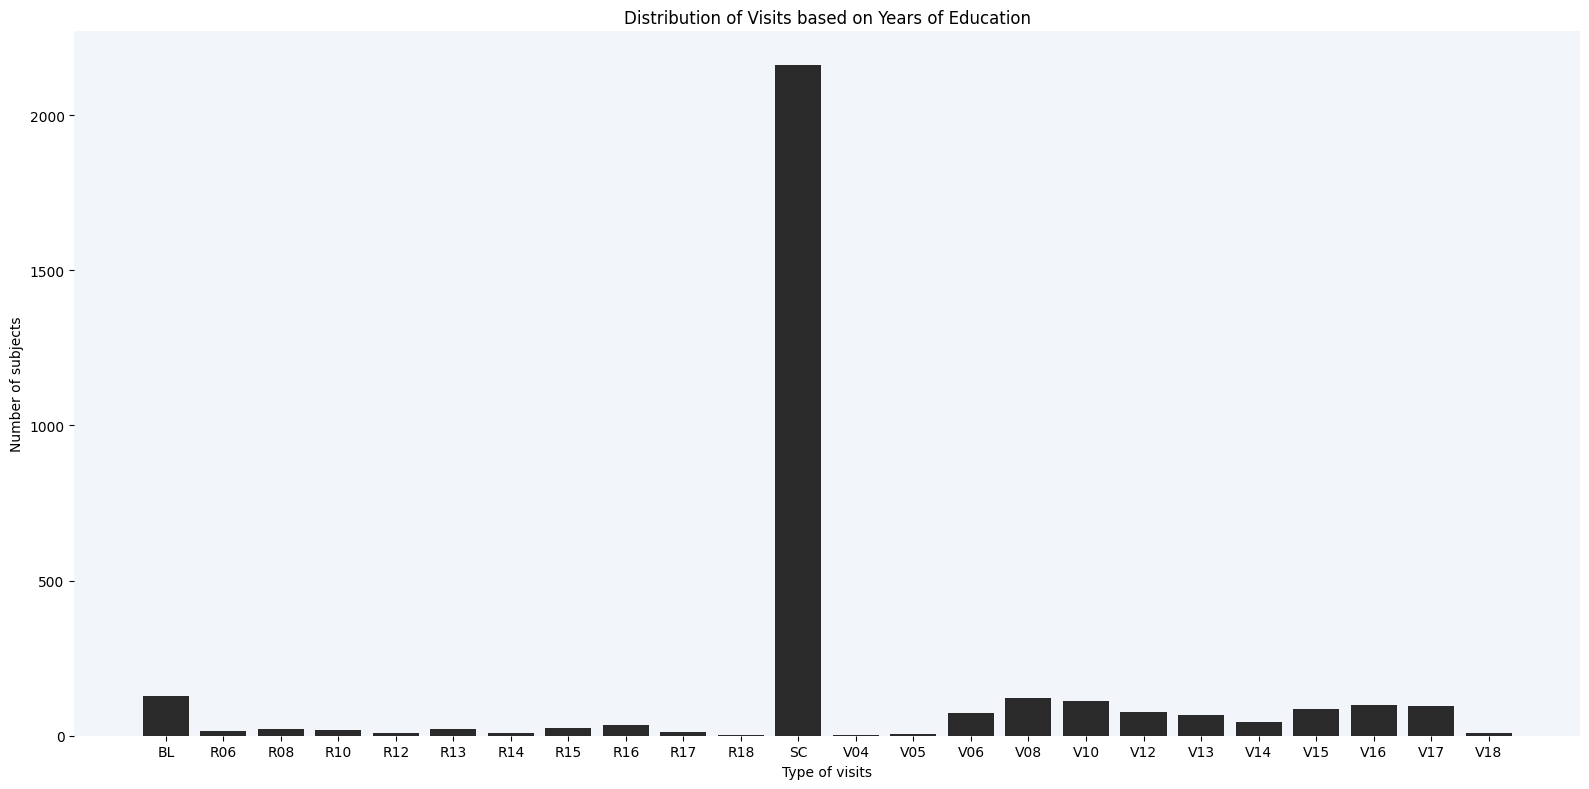

In [11]:
socioecon_df = pd.read_csv("inputs/study_files/Socio-Economics.csv", usecols=["PATNO", "EVENT_ID", "EDUCYRS"])
events = socioecon_df.groupby("EVENT_ID").size()

plt.bar(events.index.astype(str), events.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Type of visits")
plt.title("Distribution of Visits based on Years of Education");

We obtain the following distribution of education years at screening:

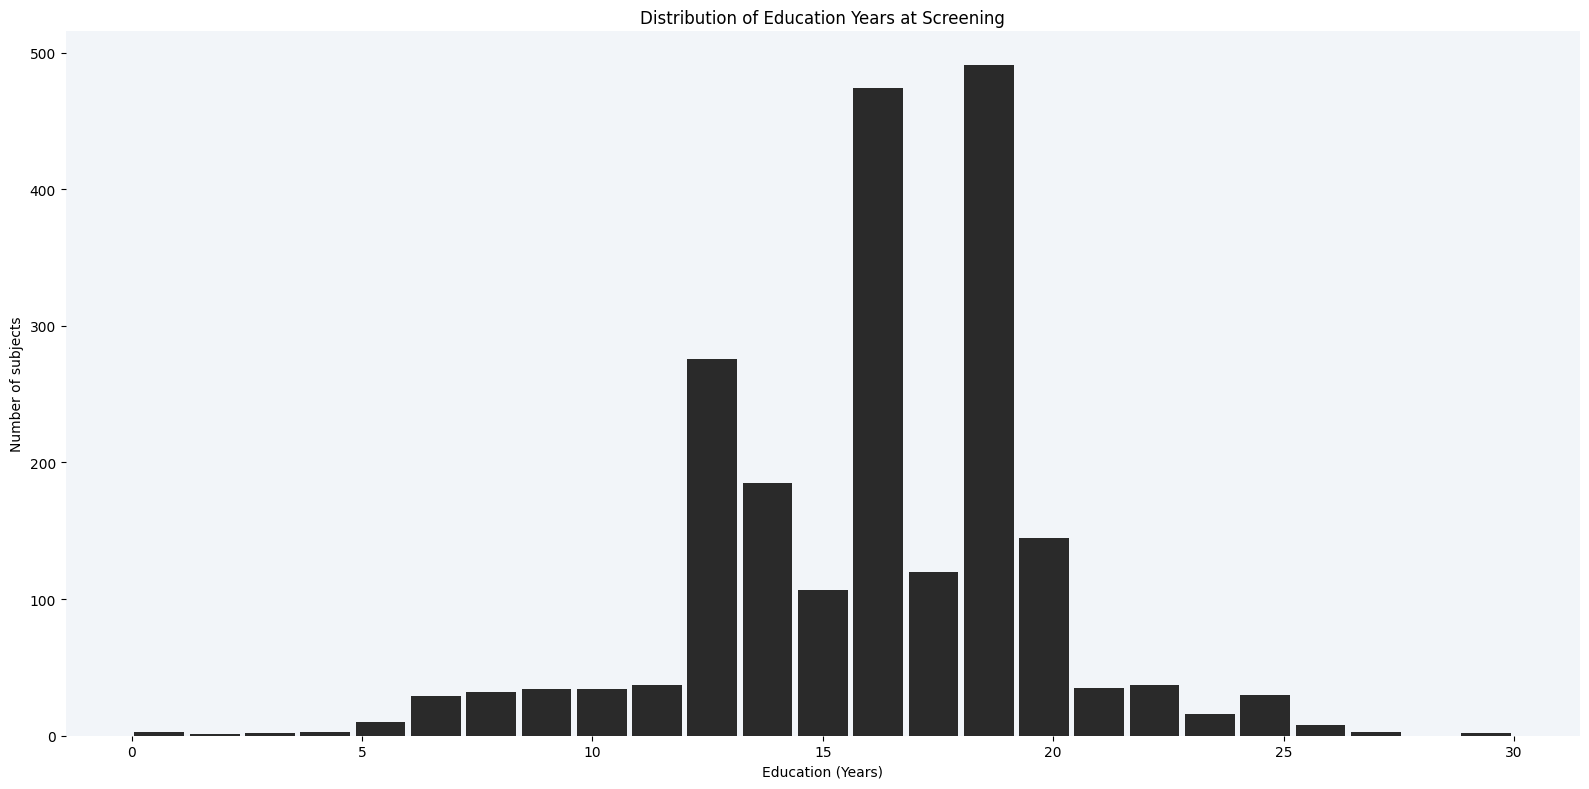

In [12]:
socioecon_df = socioecon_df[socioecon_df["EVENT_ID"] == "SC"]
socioecon_df = socioecon_df[["PATNO", "EDUCYRS"]]

socioecon_df["EDUCYRS"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.ylabel("Number of subjects")
plt.xlabel("Education (Years)")
plt.title("Distribution of Education Years at Screening");

In [13]:
# Range of education years
print("Education Years Range: ", socioecon_df["EDUCYRS"].min(), "-", 
      socioecon_df["EDUCYRS"].max())

Education Years Range:  0.0 - 30.0


### Disease duration

Similar to the previous section, we will only use PD diagnosis duration taken at screening since it has the most records as shown in the graph below. 

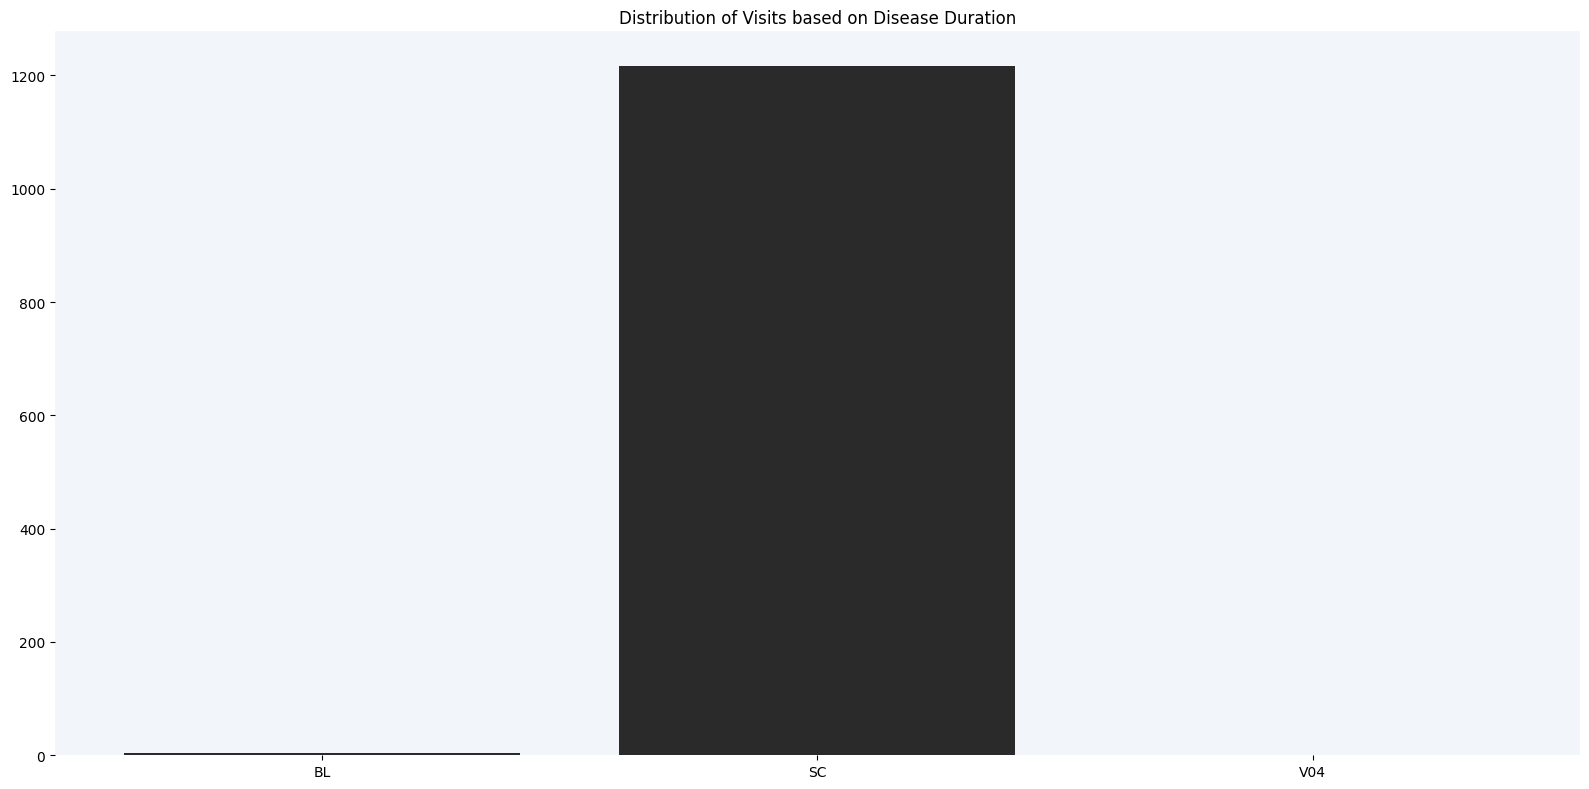

In [14]:
pddxdt_df = pd.read_csv("inputs/study_files/PD_Diagnosis_History.csv", usecols=["PATNO", "EVENT_ID", "PDDXDT"])

events = pddxdt_df.groupby("EVENT_ID").size()

plt.bar(events.index.astype(str), events.values, color=color)
plt.title("Distribution of Visits based on Disease Duration");

We obtain the following distribution of disease duration:

Download skipped: No missing files!


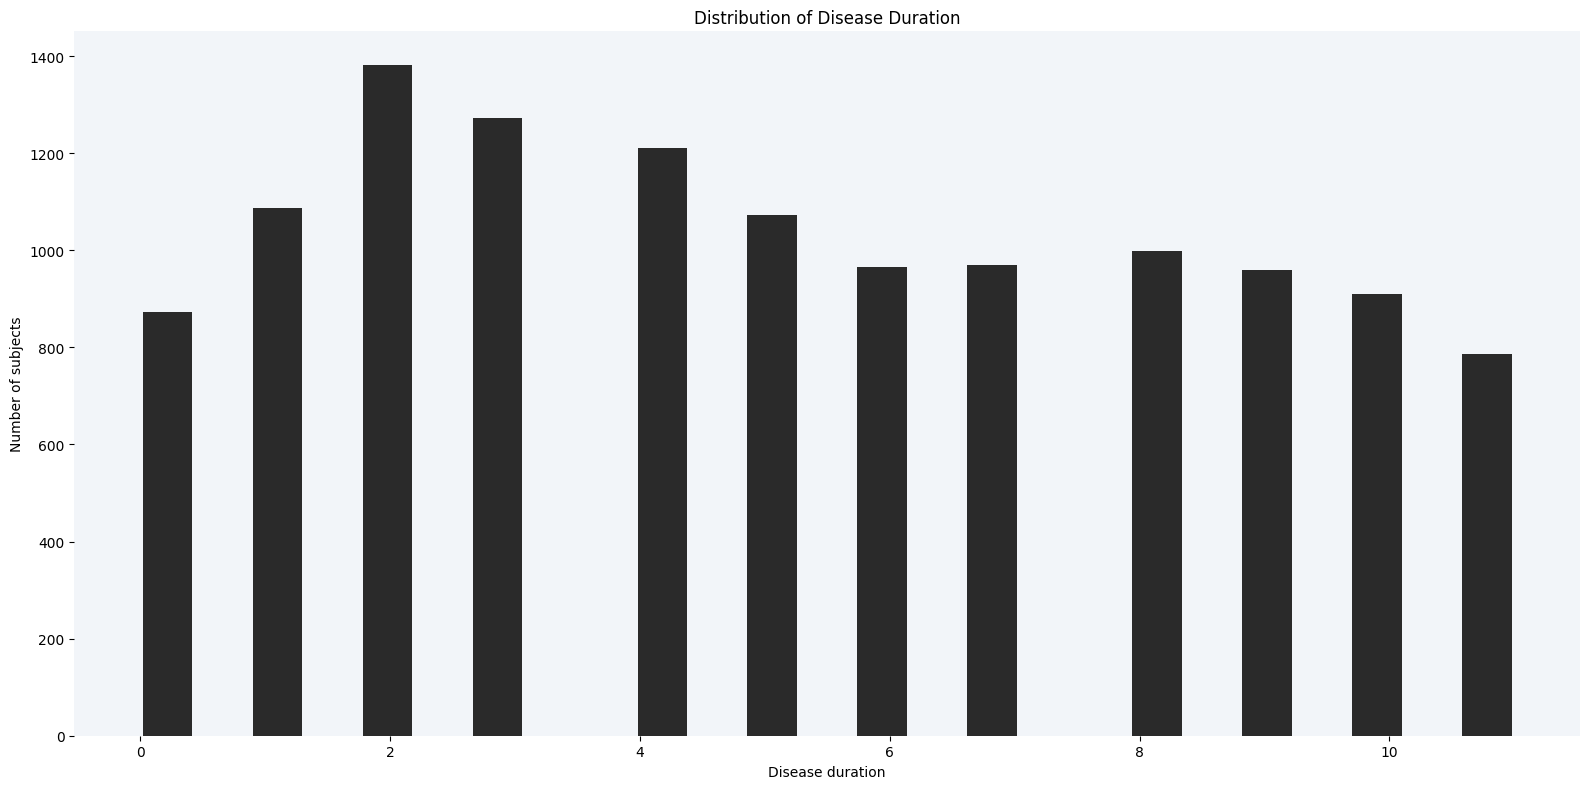

In [15]:
pdxdur_df = utils.disease_duration()

pdxdur_df["PDXDUR"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.ylabel("Number of subjects")
plt.xlabel("Disease duration")
plt.title("Distribution of Disease Duration");

### Clinical Characteristics
### Levodopa equivalent daily dose (LEDD)

Likewise, as seen in the graph below, LEDD was mostly recorded at logs. Therefore, we will only consider LEDD at logs.

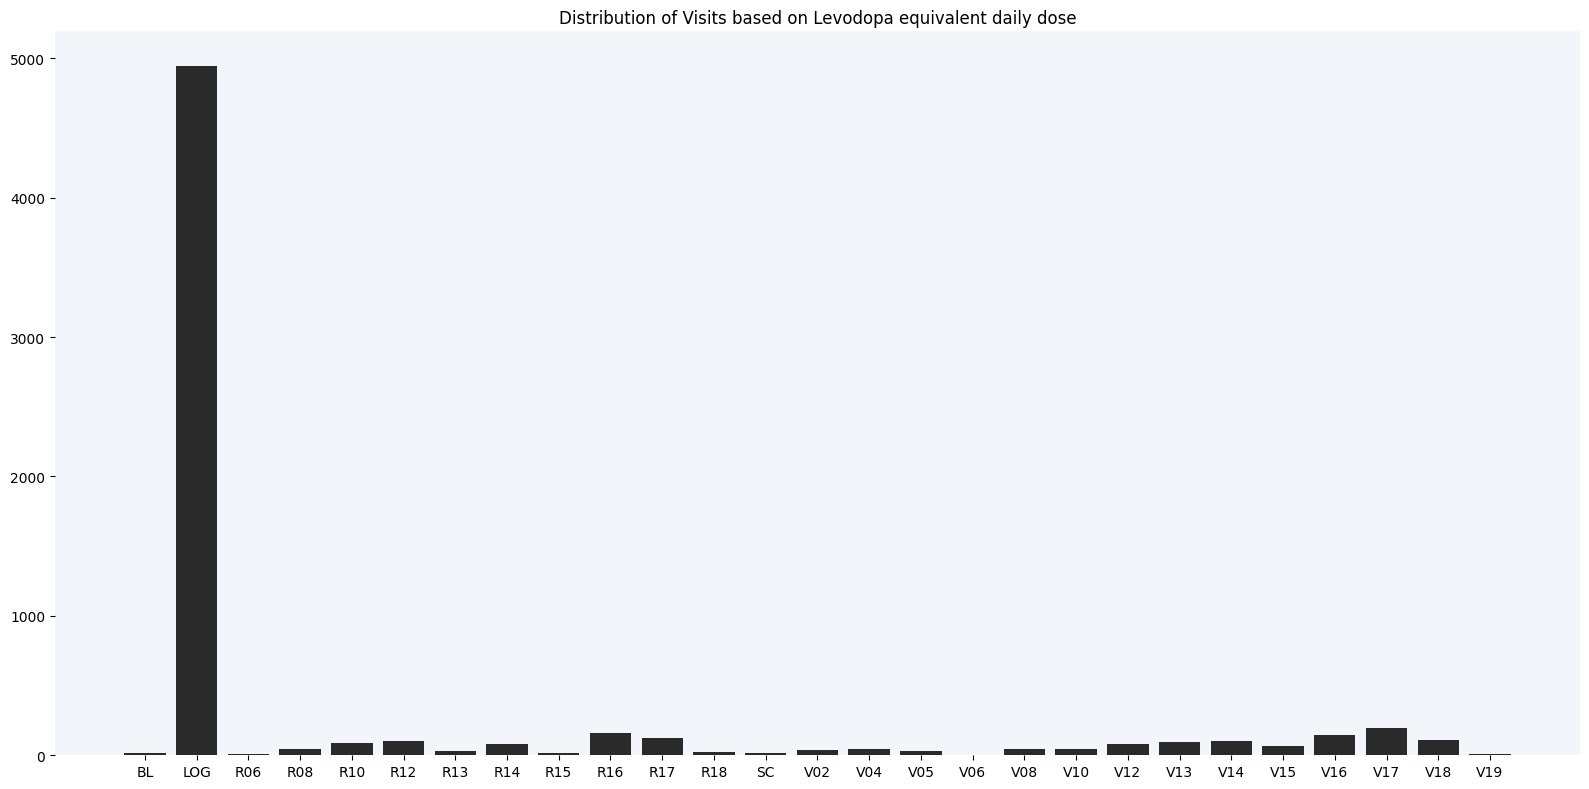

In [16]:
ledd_df = pd.read_csv("inputs/study_files/LEDD_Concomitant_Medication_Log.csv",
                     usecols=["PATNO", "EVENT_ID", "LEDD"])

events = ledd_df.groupby(["EVENT_ID"]).size()
plt.bar(events.index.astype(str), events.values, color=color)
plt.title("Distribution of Visits based on Levodopa equivalent daily dose");

The distribution of LEDD is as follows:

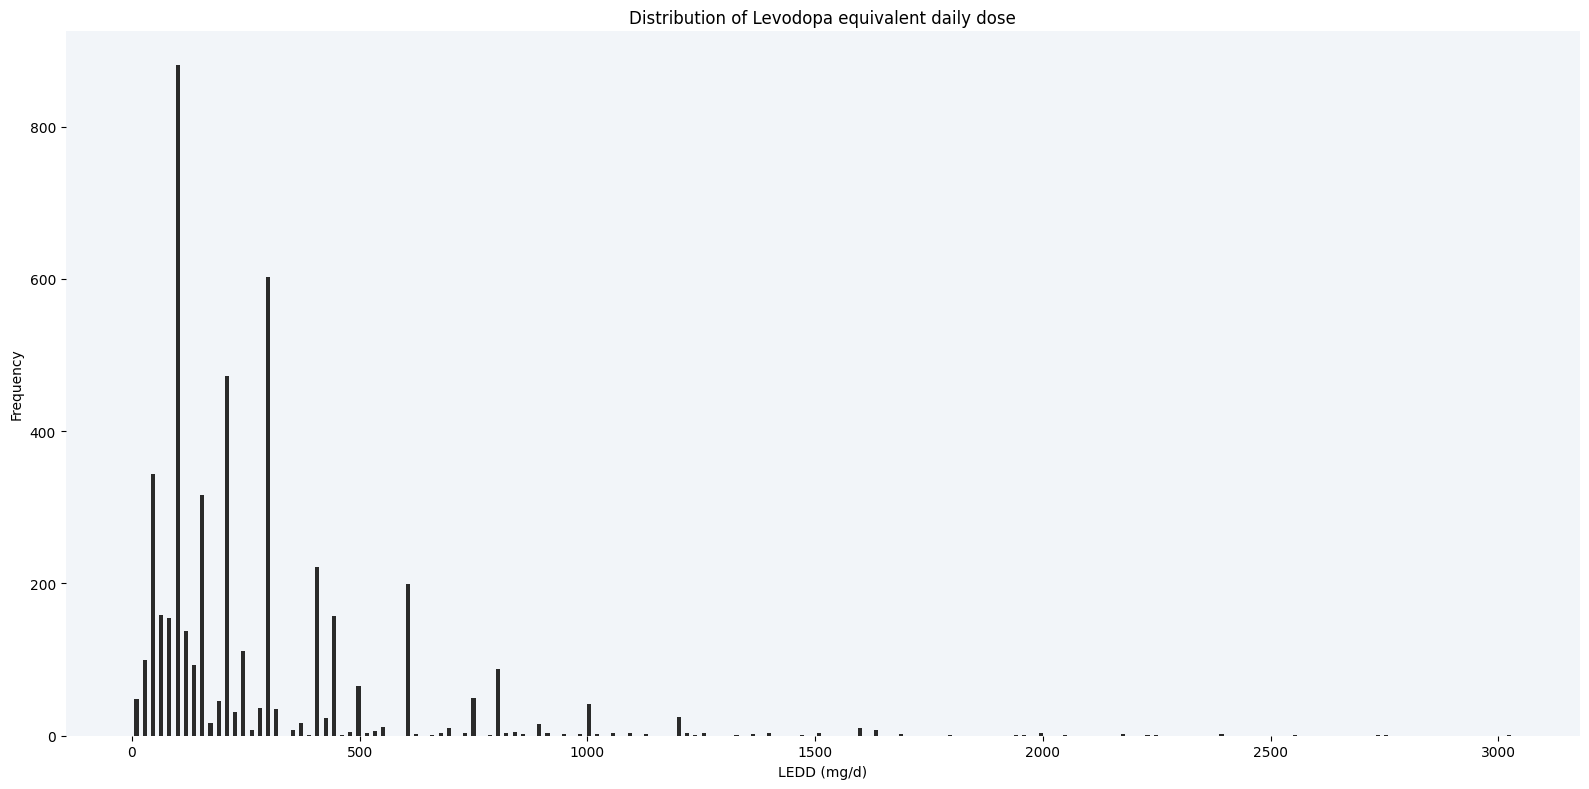

In [17]:
ledd_df = ledd_df[ledd_df["EVENT_ID"] == "LOG"]
ledd_df = ledd_df[["PATNO", "LEDD"]]

# For PD medications except COMT inhibitors, the column LEDD will show the value of the
# Levodopa equivalent dose for that medication. 

# For COMT inhibitors, the column LEDD will read “LD x 0.33” (for Entacapone) or “LD x 0.5” 
# (for Tolcapone). 

# To find the LEDD for COMT inhibitors, first find the total dose of Levodopa only, 
# and then multiply the Levodopa dose by either 0.33 or 0.5 as instructed. 

# Since Levodopa dose is mostly missing we will drop those.

ledd_df = ledd_df[ledd_df["LEDD"].notna()] # Drop nan
ledd_df = ledd_df[ledd_df["LEDD"] != "LD x 0.33"] # Drop LD x 0.33
ledd_df = ledd_df[ledd_df["LEDD"] != "LD x 0.5"] # Drop LD x 0.5

ledd_df["LEDD"] = ledd_df["LEDD"].astype('float32')

ledd = ledd_df.groupby(["LEDD"]).size()

plt.hist(ledd_df['LEDD'], zorder=3, color=color, bins=len(ledd.index),rwidth=0.5)
plt.xlabel('LEDD (mg/d)')
plt.ylabel('Frequency')
plt.title("Distribution of Levodopa equivalent daily dose");

### Hoehn and Yahr staging (H&Y)

We obtain the following distribution of H&Y scores:

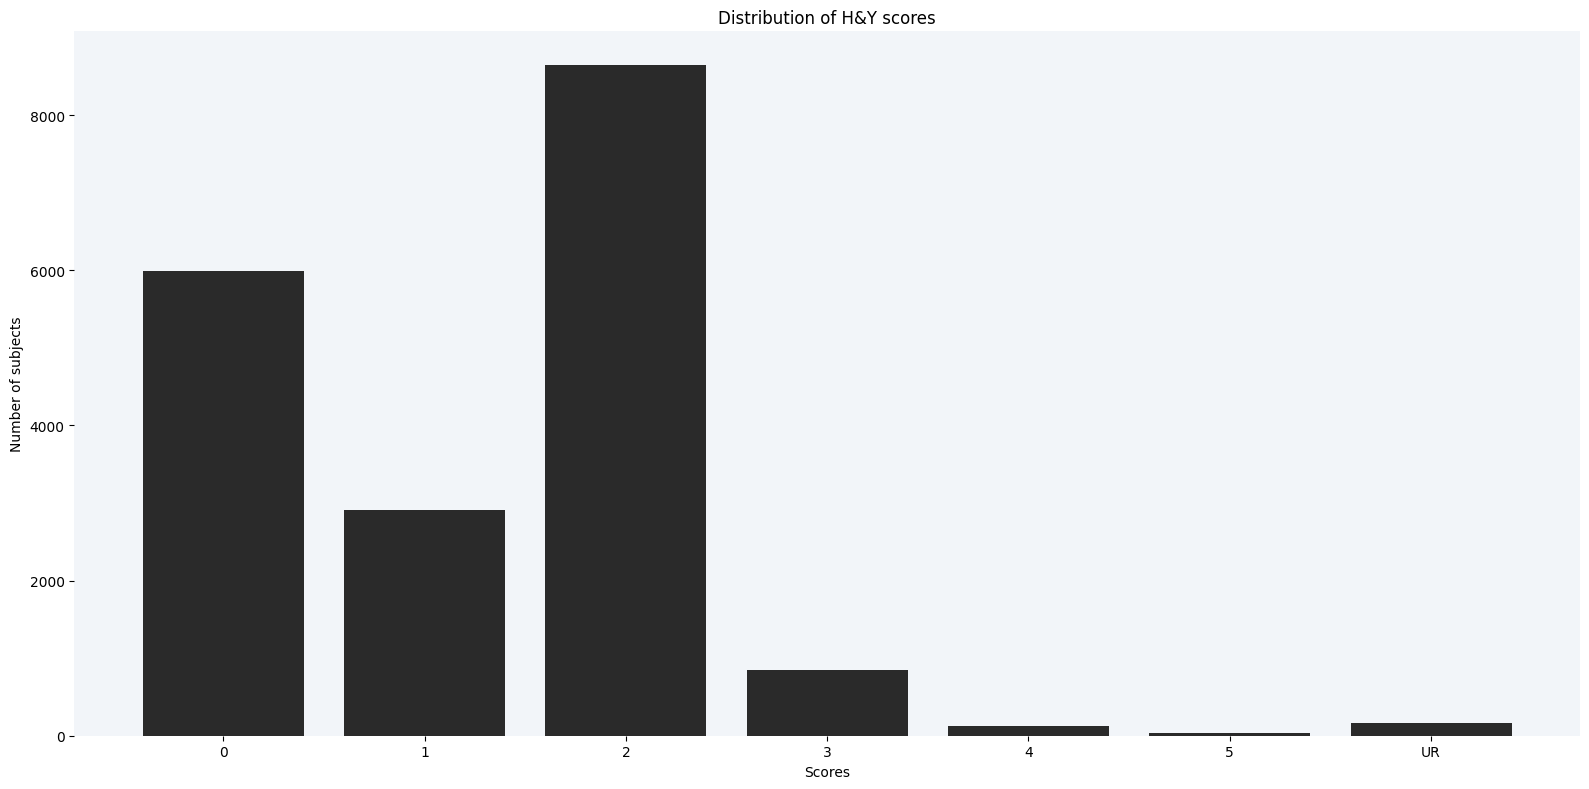

In [18]:
updrs3_df = pd.read_csv("data/MDS_UPDRS_Part_III_clean.csv",
                     usecols=["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"])
updrs3_df = updrs3_df[updrs3_df["NHY"].notna()] # Drop nan
updrs3 = updrs3_df.groupby(["NHY"], dropna=False).size()

plt.bar(updrs3.index.astype(str), updrs3.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Scores")
plt.title("Distribution of H&Y scores");

<em>UR expressed as Unable to Rate.</em>

We will remove the patients whose examiners were not able to rate the H&Y score.

In [19]:
updrs3_df = updrs3_df[updrs3_df["NHY"] != "UR"]
updrs3_df["NHY"] = pd.to_numeric(updrs3_df["NHY"])

### Unified Parkinson’s Disease Rating Scale (UPDRS III)

We obtain the following distribution of UPDRS III scores:

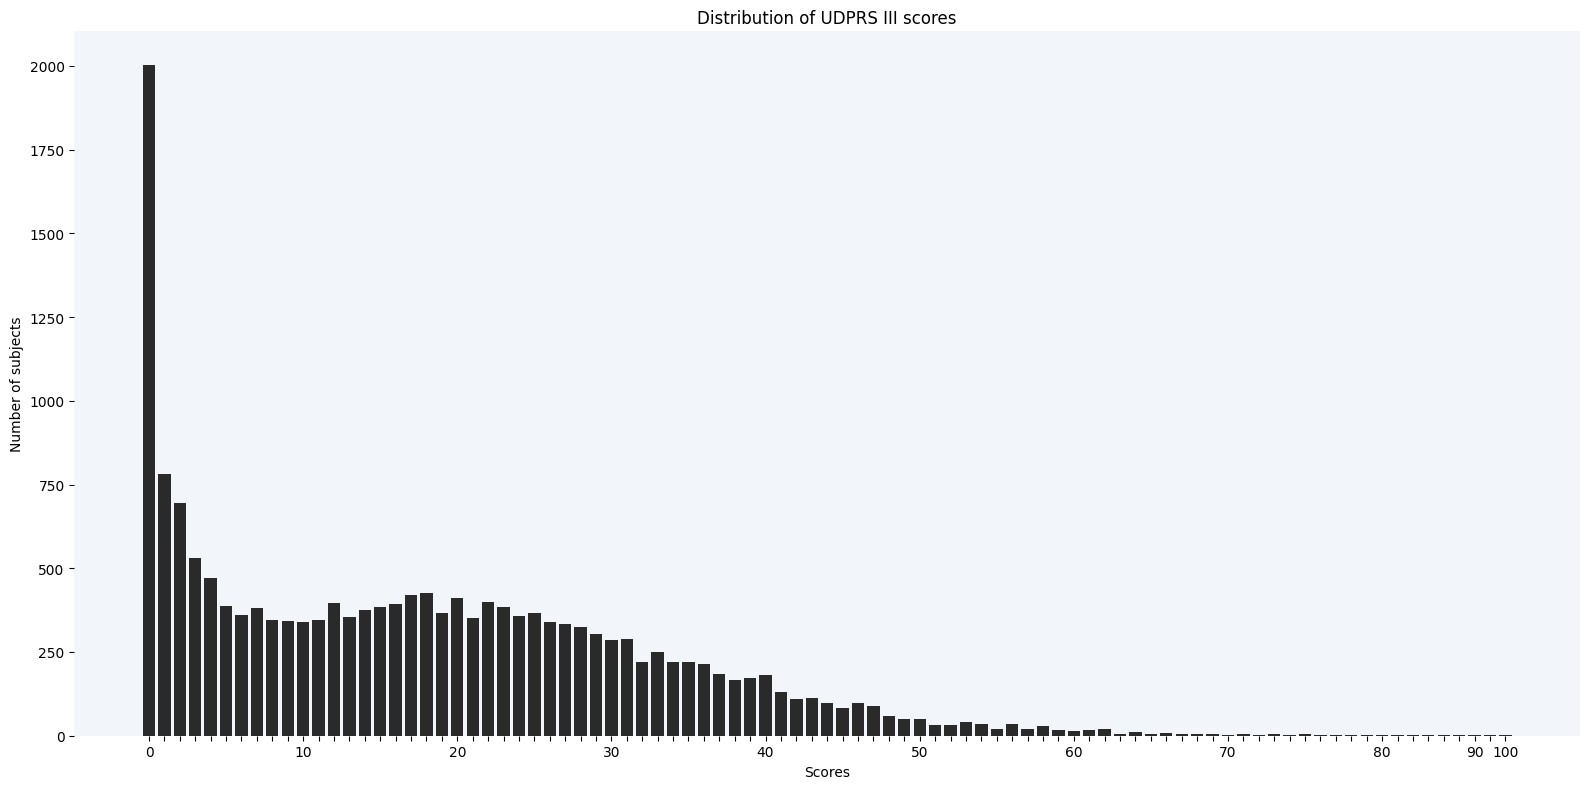

In [20]:
figure, ax = plt.subplots()

dist = updrs3_df.groupby(["NP3TOT"]).size()
plt.bar(dist.index.astype(str), dist.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Scores")
plt.title("Distribution of UDPRS III scores")

utils.reformat_plot_labels(dist, ax, 10)

### Montreal Cognitive Assessment (MoCA)

We obtain the following distribution of MoCA scores:

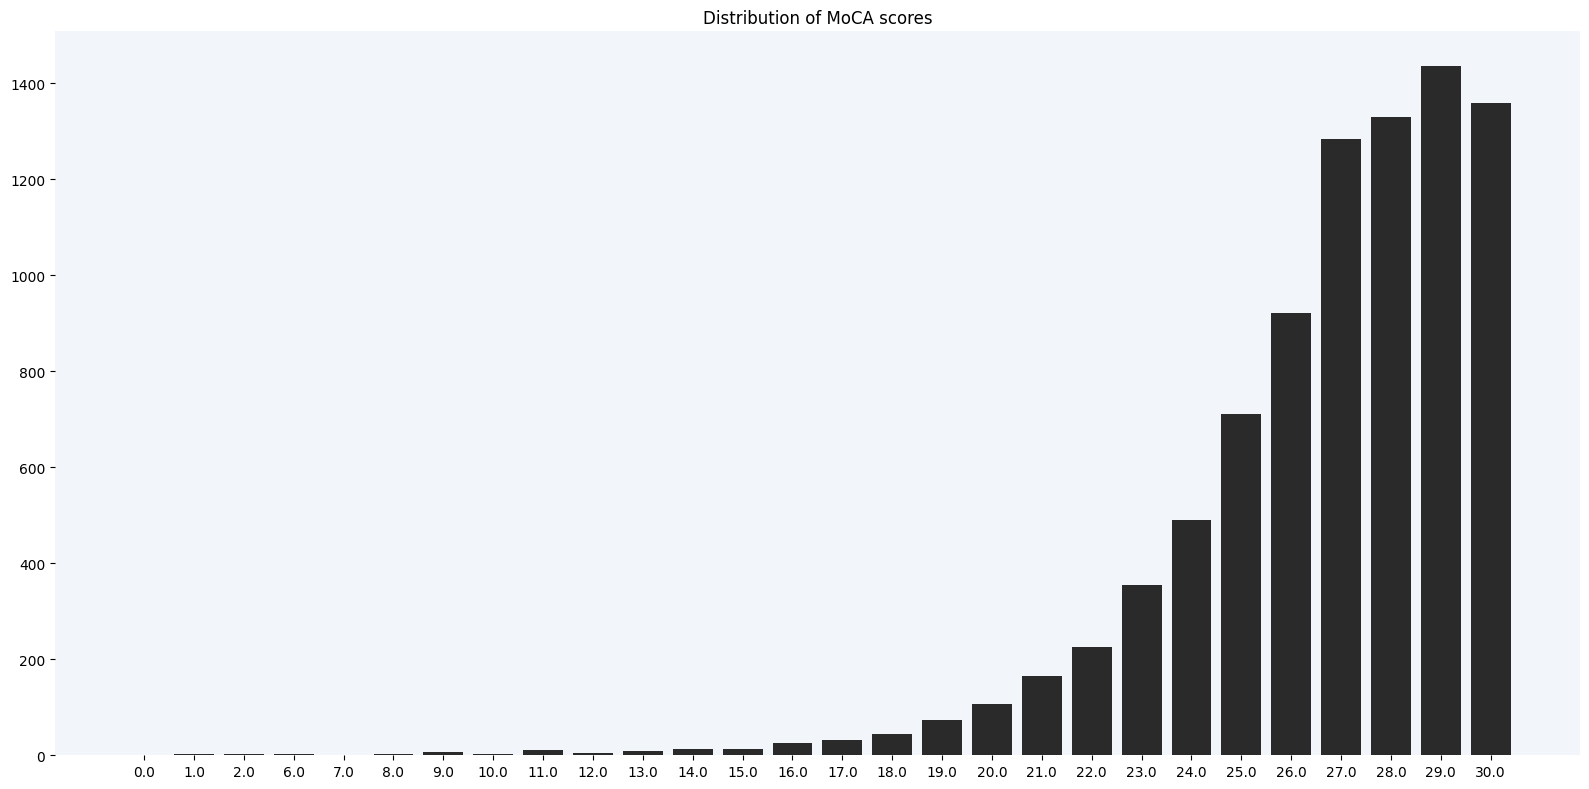

In [21]:
moca_df = pd.read_csv("inputs/study_files/Montreal_Cognitive_Assessment__MoCA_.csv",
                   usecols=["PATNO", "EVENT_ID", "MCATOT"])

# Use screening instead of baseline.
moca_df = moca_df[moca_df["EVENT_ID"] != "BL"]
moca_df["EVENT_ID"].mask(moca_df["EVENT_ID"] == "SC", "BL", inplace=True)

moca = moca_df.groupby(["MCATOT"]).size()
plt.bar(moca.index.astype(str), moca.values, color=color)
plt.title("Distribution of MoCA scores");

### Mini-Mental State Examination (MMSE)

We obtain the following distribution of MMSE scores:

0.0


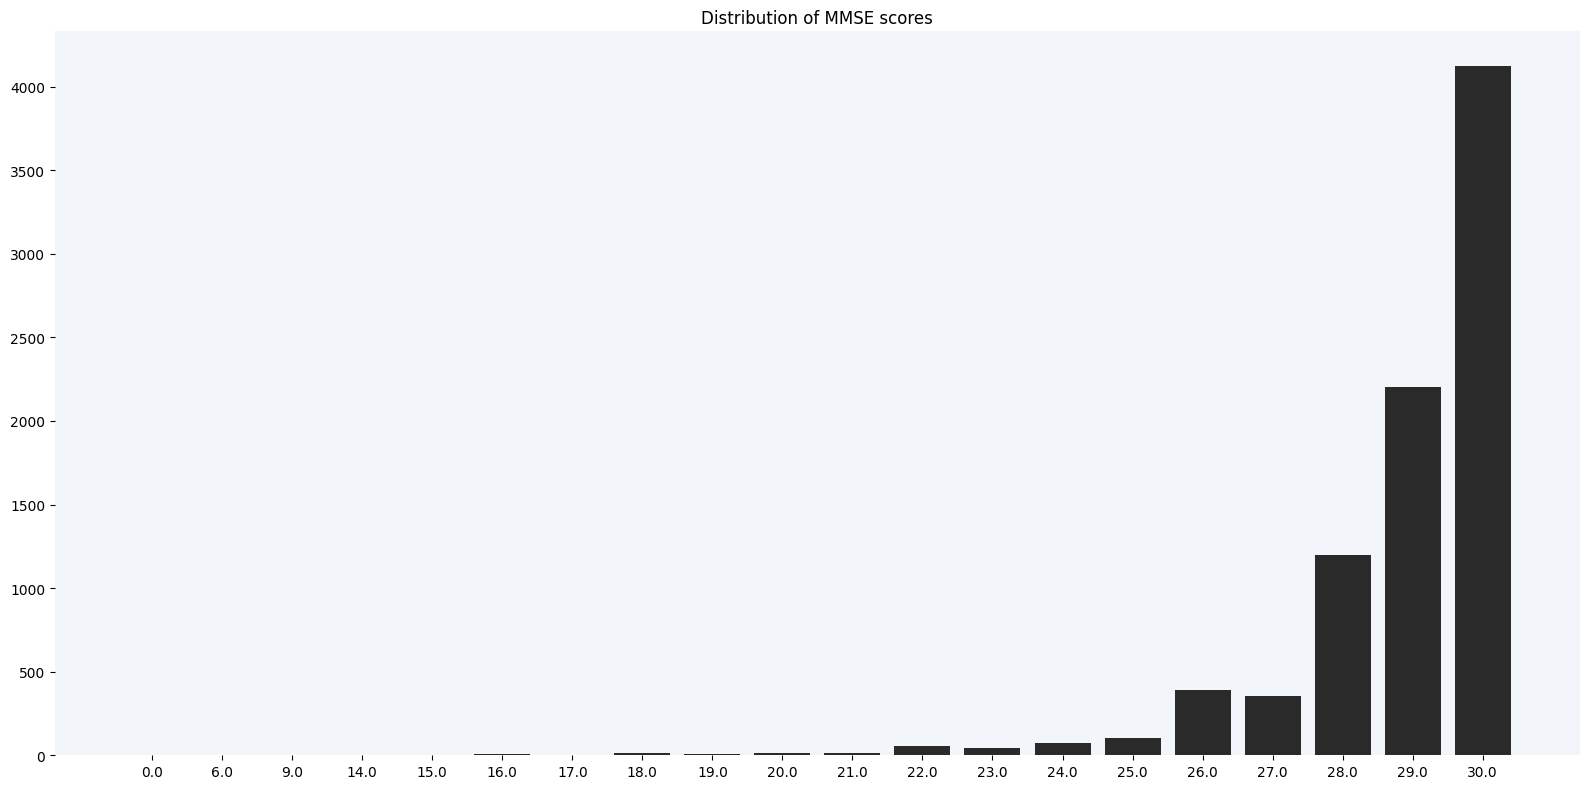

In [22]:
moca_df["MMSETOT"] = moca_df["MCATOT"].apply(utils.moca2mmse)

mmse = moca_df.groupby(["MMSETOT"]).size()

plt.bar(mmse.index.astype(str), mmse.values, color=color)
plt.title("Distribution of MMSE scores");

### Geriatric Depression Scale (GDS)

The original study used the GDS long form to calculate the GDS scores. However, GDS short form is only available in  PPMI. Therefore, the GDS scores will be out of 15 instead of 30. With this, we obtain the following distribution of GDS scores:

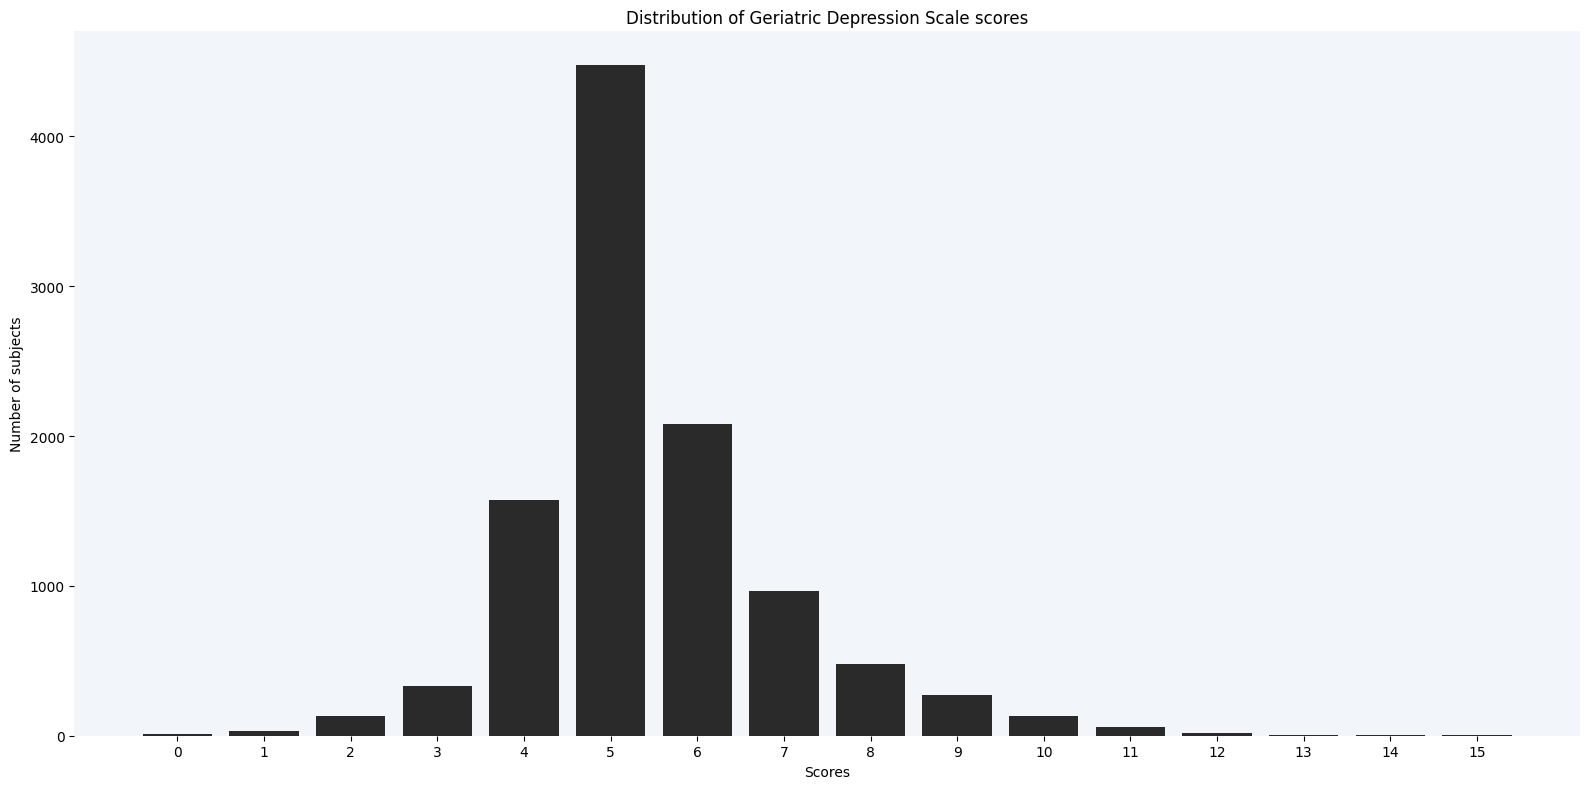

In [23]:
gdsshort_df = pd.read_csv("inputs/study_files/Geriatric_Depression_Scale__Short_Version_.csv")
gdsshort_df = gdsshort_df.drop(["REC_ID","PAG_NAME", "INFODT","ORIG_ENTRY","LAST_UPDATE"], axis=1)

# Calculate GDS score for each patients
gds = gdsshort_df.iloc[:, 2:]
gds = gds.agg(['sum'], axis="columns").rename(columns={"sum": "GDSTOT"})

# Add gds score for each patients to DF
gdsshort_df = pd.concat([gdsshort_df[['PATNO', 'EVENT_ID']], gds], axis=1)

gds = gdsshort_df.groupby(["GDSTOT"]).size()

plt.bar(gds.index.astype(int).astype(str), gds.values, color=color)
plt.ylabel("Number of subjects")
plt.xlabel("Scores")
plt.title("Distribution of Geriatric Depression Scale scores");

### MRI Availabilty

So far we have gathered both demographics and clinical characteristics from the PPMI dataset, we need to make sure that there are enough MRI available to replicate the study. To check this, we will get the distribution of events based on MRI availability.

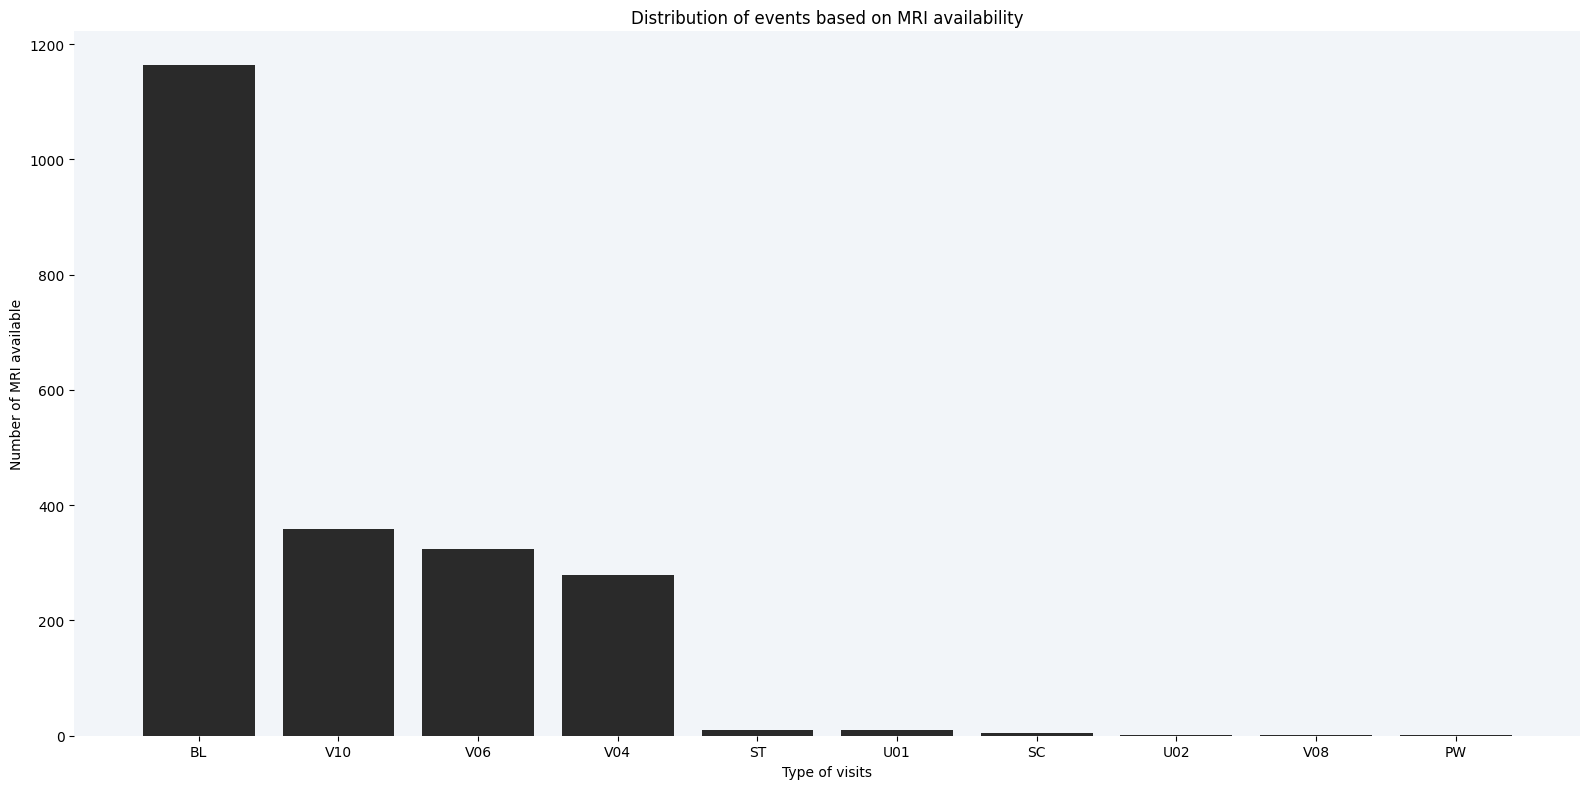

In [24]:
mri = pd.read_csv("data/MRI_info.csv")
mri["EVENT_ID"] = mri["Visit code"]
mri["PATNO"] = mri["Subject ID"]
mri["Sex"] = mri["Sex"].map({"F": 0, "M": 1})
mri = mri.drop(
    ["Subject ID", "Visit code", "Visit", "Age", "Sex", "Description"], axis=1
)
mri_events = mri.groupby("EVENT_ID").size().sort_values(ascending=False)

plt.bar(mri_events.index, mri_events.values, color=color)
plt.ylabel("Number of MRI available")
plt.xlabel("Type of visits")
plt.title("Distribution of events based on MRI availability");

As we can see in the graph above, BL (baseline), V10, V06 and V04 are the most frequent. Hence, we will only consider MRI with those visits.

### Data aggregation

Now that we have prepared all of our data, we will combine them into two respective dataframes, one for PD subjects and one for healthy controls.

Below is a summary of the number of subjects collected:

In [25]:
keys = ["PATNO", "EVENT_ID"]
pd_df = (
    cohort_def[cohort_def["COHORT"] == 1].merge(mri)
    .merge(cogstate_df, on=keys)
    .merge(age_df, on=keys)
    .merge(demo_df, on=["PATNO"])
    .merge(socioecon_df, on=["PATNO"])
    .merge(updrs3_df, on=keys)
    .merge(moca_df, on=keys)
    .merge(pdxdur_df, on=keys)
    .merge(ledd_df, on=["PATNO"])
    .merge(gdsshort_df, on=keys)
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda g: g["EVENT_ID"].nunique() > 1)
)

hc_df = (
    cohort_def[cohort_def["COHORT"] == 2].merge(mri)
    .merge(age_df, on=keys)
    .merge(demo_df, on=["PATNO"])
    .merge(socioecon_df, on=["PATNO"])
    .merge(moca_df, on=keys)
    .merge(gdsshort_df, on=keys)
    .drop_duplicates()
)

nc_patno = pd_df[pd_df["COGSTATE"] == 1]["PATNO"]
mci_patno = pd_df[pd_df["COGSTATE"] == 2]["PATNO"]

In [26]:
print(f"Unique number of HC patients: {hc_df['PATNO'].nunique()}")
print(f"Unique number of NC patients: {nc_patno.nunique()}")
print(f"Unique number of MCI patients: {mci_patno.nunique()}")

Unique number of HC patients: 172
Unique number of NC patients: 140
Unique number of MCI patients: 46


### Acceptable visit pairs

To be able to replicate our cohort, we need subjects with follow-up scans. The original study followed up each subjects for 18 months. Below we will find the number of unique PD-MCI, PD-NC and HC subjects per visit pairs.

In [27]:
maketal.find_acceptable_visit_pairs(pd_df,hc_df)

Unique PD-MCI subjects per visit pairs:
BL  & V04 =   2 | Month difference:                 12
BL  & V06 =   3 | Month difference:                 24
BL  & V10 =   3 | Month difference:                 48
V04 & V06 =  12 | Month difference:                 12
V04 & V10 =   9 | Month difference:                 36
V06 & V10 =  17 | Month difference:                 24

Unique PD-NC subjects per visit pairs:
BL  & V04 =  30 | Month difference:                 12
BL  & V06 =  42 | Month difference:                 24
BL  & V10 =  33 | Month difference:                 48
V04 & V06 =  72 | Month difference:                 12
V04 & V10 =  63 | Month difference:                 36
V06 & V10 =  83 | Month difference:                 24

Unique HC subjects per visit pairs:
BL  & V04 =  63 | Month difference:                 12
BL  & V06 =   9 | Month difference:                 24
BL  & V08 =   2 | Month difference:                 36
BL  & V10 =  12 | Month difference:                 48
V04

Since the number of MCI subjects is quite low, we will focus on the pairs of visit that has the most number of MCI subjects, i.e, we will use a time interval of 12 and 24 months to replicate our cohort.

Now that the number of the months between baseline and follow-up is determined, we can now proceed to cohort matching.

## Cohort Summary

In [28]:
def cohort_summary(*, hc, nc, mci, title):
    def gen_row(D, *, agg, col, f="4.1f", sep=" ± "):
        if not isinstance(agg, str) and isinstance(agg, Iterable):
            return [f"{sep}".join([f"{d.loc[a][col]:{f}}" for a in agg]) for d in D]
        else:
            return [f"{d.loc[agg][col]:{f}}" for d in D]

    def gender_ratio(df):
        male_count = df[df["SEX"] == 1]["PATNO"].nunique()
        return f"{male_count:.0f}, {male_count / df['PATNO'].nunique() * 100:.1f}%"

    D = [hc.describe(), nc.describe(), mci.describe()]

    table = Table(title=title, box=rich.box.HORIZONTALS, show_footer=True, expand=True,
                  style="#cfd5e4", row_styles=["on #f2f5f9", ""])

    table.add_column( footer="Values expressed as mean ± SD.")
    table.add_column("Healthy Controls")
    table.add_column("PD-NC")
    table.add_column("PD-MCI")
#     table.add_column("[italic]P[not italic]-value")  # TODO
    
    table.add_row("n", *gen_row(D, agg="count", col="PATNO", f=".0f"))
    table.add_row("Age (y)", *gen_row(D, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row(
        "Age range", *gen_row(D, agg=["min", "max"], col="AGE_AT_VISIT", sep=" - ")
    )
    table.add_row(
        "Gender (male, %)", gender_ratio(hc), gender_ratio(nc), gender_ratio(mci)
    )
    table.add_row("Education (y)", *gen_row(D, agg=["mean", "std"], col="EDUCYRS"))
    table.add_row(
        "Disease duration (mo)", "", *gen_row(D[1:], agg=["mean", "std"], col="PDXDUR")
    )
    table.add_row("LEDD (mg/d) baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD"))
    table.add_row("LEDD (mg/d) follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD_NX"))
    table.add_row("H&Y baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY"))
    table.add_row("H&Y follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY_NX"))
    table.add_row("UPDRS III baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT"))
    table.add_row(
        "UPDRS III follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT_NX")
    )
    table.add_row("MMSE baseline", *gen_row(D, agg=["mean", "std"], col="MMSETOT"))
    table.add_row("MMSE follow-up", *gen_row(D, agg=["mean", "std"], col="MMSETOT_NX"))
    table.add_row("MoCA baseline", *gen_row(D, agg=["mean", "std"], col="MCATOT"))
    table.add_row("MoCA follow-up", *gen_row(D, agg=["mean", "std"], col="MCATOT_NX"))
    table.add_row("GDS baseline", *gen_row(D, agg=["mean", "std"], col="GDSTOT"))
    table.add_row("GDS follow-up", *gen_row(D, agg=["mean", "std"], col="GDSTOT_NX"))

    console = Console()
    console.print(table)

### Cohort with follow-up after 12 months

In [29]:
mci, nc, hc = maketal.create_cohort(pd_df=pd_df, hc_df=hc_df, months=12)

print(
    f"""Unique number of:
  - HC subjects:     {hc['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  64 (/66)
  - PD-MCI subjects: 13 (/39)



With a follow-up of 12 months, more than 60% of PD-MCI subjects are missing. 

In [30]:
cohort_summary(
    hc=hc,
    nc=nc,
    mci=mci,
    title="Demographic and clinical characteristics\n(12 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                               (12 months follow-up)                                               
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            37                        64                    13                  
  Age (y)                                      57.8 ± 12.4               59.8 ±  9.9           65.3 ±  8.5         
  Age range                                    30.6 - 78.8               38.3 - 82.3           50.4 - 72.7         
  Gender (male, %)                             22, 59.5%                 40, 62.5%             9, 69.2%            
  Education (y)                                14.9 ±  2.9               15.0 ±  3.0           15.1 ±  2.9         
  Disease duration (mo)                                                   4.1 ±  2.8            4.8 ±  4.0         
  LEDD (mg/d) baseline                                                   262.0 ± 255.4         240.9 ± 206.9       
  LEDD (mg/d) follow-up                                                  262.0 ± 255.4         240.9 ± 206.9       
  H&Y baseline                                                            1.6 ±  0.6            1.8 ±  0.6         
  H&Y follow-up                                                           1.7 ±  0.5            1.7 ±  0.5         
  UPDRS III baseline                                                     19.9 ±  9.8           21.5 ± 11.9         
  UPDRS III follow-up                                                    21.4 ± 10.9           25.3 ± 12.8         
  MMSE baseline                                29.6 ±  0.5               29.3 ±  1.0           28.2 ±  1.1         
  MMSE follow-up                               29.3 ±  0.8               29.4 ±  0.9           28.4 ±  1.4         
  MoCA baseline                                28.2 ±  1.2               27.5 ±  2.1           25.1 ±  2.3         
  MoCA follow-up                               27.4 ±  2.0               27.5 ±  2.1           25.6 ±  2.8         
  GDS baseline                                  5.0 ±  1.2                5.4 ±  1.5            5.5 ±  1.2         
  GDS follow-up                                 5.1 ±  1.2                5.3 ±  1.6            5.6 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

### Cohort with follow-up after 24 months

In [31]:
mci_, nc_, hc_ = maketal.create_cohort(pd_df=pd_df, hc_df=hc_df, months=24)

print(
    f"""Unique number of:
  - HC subjects:     {hc_['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci_['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     9 (/37)
  - PD-NC subjects:  64 (/66)
  - PD-MCI subjects: 19 (/39)



With a follow-up of 24 months, 75% of Healthy Controls and more than 50% of PD-MCI subjects are missing.

In [32]:
cohort_summary(
    hc=hc_,
    nc=nc_,
    mci=mci_,
    title="Demographic and clinical characteristics\n(24 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                               (24 months follow-up)                                               
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            9                         64                    19                  
  Age (y)                                      54.6 ± 15.5               61.9 ±  8.9           66.1 ±  8.6         
  Age range                                    30.6 - 76.8               38.3 - 77.5           49.9 - 79.2         
  Gender (male, %)                             6, 66.7%                  38, 59.4%             16, 84.2%           
  Education (y)                                14.2 ±  4.3               16.0 ±  3.0           15.1 ±  3.1         
  Disease duration (mo)                                                   4.7 ±  2.8            5.1 ±  3.1         
  LEDD (mg/d) baseline                                                   246.0 ± 230.7         297.4 ± 287.2       
  LEDD (mg/d) follow-up                                                  246.0 ± 230.7         297.4 ± 287.2       
  H&Y baseline                                                            1.7 ±  0.5            1.9 ±  0.2         
  H&Y follow-up                                                           1.7 ±  0.5            2.1 ±  0.6         
  UPDRS III baseline                                                     21.7 ± 10.8           26.8 ± 10.0         
  UPDRS III follow-up                                                    22.5 ± 11.4           27.3 ± 12.5         
  MMSE baseline                                29.8 ±  0.4               29.3 ±  1.0           28.5 ±  0.7         
  MMSE follow-up                               29.8 ±  0.4               29.3 ±  1.0           28.3 ±  1.4         
  MoCA baseline                                29.0 ±  1.2               27.5 ±  2.2           25.6 ±  1.6         
  MoCA follow-up                               28.7 ±  1.1               27.5 ±  2.1           25.3 ±  2.6         
  GDS baseline                                  5.1 ±  0.6                5.2 ±  1.4            6.1 ±  1.9         
  GDS follow-up                                 5.0 ±  0.5                5.2 ±  1.3            6.0 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

### Cohort follow up after both 12 and 24 months

Since the two previous cohorts are no where near the original paper's cohort, we will try to merge subjects with both a follow-up of 12 and 24 months in one cohort.

In [33]:
# Merging PD-MCI
mci_mix = pd.concat([mci, mci_])
mci_mix = mci_mix.sample(frac=1, random_state=42)
mci_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Merging PD-NC
nc_mix = pd.concat([nc, nc_])
nc_mix = nc_mix.sample(frac=1, random_state=42)
nc_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Merging HC subjecs
hc_mix = pd.concat([hc, hc_])
hc_mix = hc_mix.sample(frac=1, random_state=42)
hc_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

hc_mix = hc_mix.head(37)
nc_mix = nc_mix.head(66)

print(
    f"""Unique number of:
  - HC subjects:     {hc_mix['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_mix['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci_mix['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  66 (/66)
  - PD-MCI subjects: 28 (/39)



By doing so, we were able to collect more than 70% of PD-MCI subjects. This is by far the closest we can get to the original cohort.

In [34]:
cohort_summary(
    hc=hc_mix,
    nc=nc_mix,
    mci=mci_mix,
    title="Demographic and clinical characteristics\n(12 & 24 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                            (12 & 24 months follow-up)                                             
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            37                        66                    28                  
  Age (y)                                      57.9 ± 12.5               59.6 ±  9.6           65.2 ±  8.8         
  Age range                                    30.6 - 78.8               38.3 - 82.3           49.9 - 79.2         
  Gender (male, %)                             22, 59.5%                 41, 62.1%             21, 75.0%           
  Education (y)                                15.1 ±  3.1               15.2 ±  3.1           15.2 ±  2.9         
  Disease duration (mo)                                                   4.0 ±  2.6            4.9 ±  3.4         
  LEDD (mg/d) baseline                                                   240.1 ± 241.2         285.4 ± 263.0       
  LEDD (mg/d) follow-up                                                  240.1 ± 241.2         285.4 ± 263.0       
  H&Y baseline                                                            1.6 ±  0.5            1.9 ±  0.4         
  H&Y follow-up                                                           1.6 ±  0.5            1.9 ±  0.4         
  UPDRS III baseline                                                     19.6 ±  9.9           25.5 ± 10.4         
  UPDRS III follow-up                                                    20.2 ± 10.5           25.8 ± 12.0         
  MMSE baseline                                29.6 ±  0.5               29.2 ±  1.2           28.5 ±  0.8         
  MMSE follow-up                               29.3 ±  0.8               29.3 ±  0.9           28.3 ±  1.5         
  MoCA baseline                                28.2 ±  1.2               27.3 ±  2.4           25.6 ±  1.8         
  MoCA follow-up                               27.3 ±  1.8               27.4 ±  2.2           25.4 ±  2.7         
  GDS baseline                                  5.1 ±  1.2                5.6 ±  1.4            5.9 ±  1.7         
  GDS follow-up                                 5.1 ±  1.3                5.4 ±  1.6            5.8 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

## Image Pre-Processing

In [35]:
# TODO: Download missing imaging data from PPMI.
# utils.download_missing_nifti_files(...)
# Boutique code (SPM func)
# or
# SLURM
# or
# Pull freesurfer results from server